In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install faiss-cpu transformers sentence-transformers
from sentence_transformers import SentenceTransformer

In [2]:
import pandas as pd
import numpy as np
import os

In [32]:
data = '/content/drive/MyDrive/Colab Notebooks/Data.csv'

data = pd.read_csv(data)['0']

In [35]:
paragraphs = list(data)

In [43]:
len(paragraphs)

4405

In [37]:
model = SentenceTransformer('DeepPavlov/rubert-base-cased')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
len(data)

4405

In [44]:
os.makedirs('vector_chunks', exist_ok=True)

chunk_size = 100

for i in range(0, len(data),chunk_size):
    chunk = paragraphs[i:i + chunk_size]

    paragraph_vectors = model.encode(chunk)

    chunk_filename = f'vector_chunks/paragraph_vectors_{i//chunk_size}.npy'
    np.save(chunk_filename, paragraph_vectors)

    print(f"Сохранен {i//chunk_size+1}-й файл из {len(paragraphs)//chunk_size+1}")

Сохранен 1-й файл из 45
Сохранен 2-й файл из 45
Сохранен 3-й файл из 45
Сохранен 4-й файл из 45
Сохранен 5-й файл из 45
Сохранен 6-й файл из 45
Сохранен 7-й файл из 45
Сохранен 8-й файл из 45
Сохранен 9-й файл из 45
Сохранен 10-й файл из 45
Сохранен 11-й файл из 45
Сохранен 12-й файл из 45
Сохранен 13-й файл из 45
Сохранен 14-й файл из 45
Сохранен 15-й файл из 45
Сохранен 16-й файл из 45
Сохранен 17-й файл из 45
Сохранен 18-й файл из 45
Сохранен 19-й файл из 45
Сохранен 20-й файл из 45
Сохранен 21-й файл из 45
Сохранен 22-й файл из 45
Сохранен 23-й файл из 45
Сохранен 24-й файл из 45
Сохранен 25-й файл из 45
Сохранен 26-й файл из 45
Сохранен 27-й файл из 45
Сохранен 28-й файл из 45
Сохранен 29-й файл из 45
Сохранен 30-й файл из 45
Сохранен 31-й файл из 45
Сохранен 32-й файл из 45
Сохранен 33-й файл из 45
Сохранен 34-й файл из 45
Сохранен 35-й файл из 45
Сохранен 36-й файл из 45
Сохранен 37-й файл из 45
Сохранен 38-й файл из 45
Сохранен 39-й файл из 45
Сохранен 40-й файл из 45
Сохранен 

In [7]:
vector_files = sorted([f for f in os.listdir('vector_chunks') if f.startswith('paragraph_vectors_')])

all_vectors = []
for vf in vector_files:
    vectors = np.load(os.path.join('vector_chunks', vf))
    all_vectors.append(vectors)

all_vectors = np.vstack(all_vectors)

print("Объединенный массив векторов имеет форму:", all_vectors.shape)

Объединенный массив векторов имеет форму: (7609, 768)


In [8]:
np.save('vectors.npy',all_vectors)

In [45]:
vectors = np.load('/content/drive/MyDrive/Colab Notebooks/VectorDatabase.npy')

In [46]:
vectors

array([[-0.10914315, -0.54184926,  0.43645987, ...,  0.34419638,
         0.30588737, -0.08790965],
       [ 0.12701242, -0.0996453 ,  0.34829476, ...,  0.57677776,
         0.10084709, -0.2083392 ],
       [-0.05400361, -0.18464245,  0.25665224, ...,  0.76138145,
         0.19022717, -0.32657257],
       ...,
       [-0.06294268, -0.10966221,  0.4368154 , ...,  0.18902077,
         0.03030941, -0.1502526 ],
       [-0.17749594, -0.24359427,  0.5945008 , ...,  0.5139676 ,
         0.35217476, -0.14289881],
       [ 0.11226061, -0.31371388,  0.23858726, ...,  0.3212714 ,
         0.38899156, -0.06647636]], dtype=float32)

In [47]:
vectors.shape

(4405, 768)

In [48]:
vectors_series = pd.Series(list(vectors))

In [49]:
import faiss

index = faiss.IndexFlatL2(vectors.shape[1])
index.add(vectors)

In [75]:
def retrieve_relevant_paragraphs(query, index, paragraphs, top_k=5):
    query_vector = model.encode([query])
    distances, indices = index.search(query_vector, top_k)
    relevant_paragraphs = [paragraphs[i] for i in indices[0]]
    return relevant_paragraphs

def augment_context(query, relevant_paragraphs):
    augmented_context = query + "\n\n" + "\n".join(relevant_paragraphs)
    return augmented_context

In [66]:
diagnoses = [
    ["Отит","ушная инфекция", "бактерии", "аллергия", "воспаление", "ушной канал", "грибок", "болезнь уха", "воск", "собака", "кошка"],
    ["Дерматит","зуд", "аллергия", "высыпания", "бактерии", "воспаление", "шерсть", "кожа", "экзема", "клещи", "раздражение"],
    ["Гастроэнтерит","рвота", "диарея", "воспаление", "желудок", "кишечник", "инфекция", "обезвоживание", "питание", "бактерии", "вирус"],
    ["Зубной камень и гингивит","зубы", "десны", "бактерии", "воспаление", "ротовая полость", "гигиена", "зубной налет", "кровоточивость", "пародонтит", "пища"],
    ["Паразитарные инфекции","глисты", "блохи", "клещи", "заражение", "инвазия", "вши", "паразиты", "профилактика", "лечение", "антигельминтики"],
    ["Цистит","мочевой пузырь", "воспаление", "инфекция", "моча", "дизурия", "бактерии", "дискомфорт", "мочеиспускание", "стерильный", "антибиотики"],
    ["Артикулярные заболевания (артрит)","суставы", "боль", "воспаление", "хромота", "артроз", "пожилые животные", "обезболивание", "хондропротекторы", "остеоартрит", "скованность"],
    ["Пиометра","матка", "гной", "воспаление", "инфекция", "сук", "стерилизация", "гормоны", "абсцесс", "пирометрит", "высокая температура"],
    ["Аллергические реакции","гистамин", "зуд", "высыпания", "воспаление", "аллерген", "пищевые аллергии", "ингаляционные аллергии", "кожные тесты", "анафилаксия", "антигистаминные"],
    ["Панкреатит","поджелудочная железа", "воспаление", "рвота", "боль", "диета", "ферменты", "анализы", "обезвоживание", "жирная пища", "лекарства"]
]

In [100]:
strlist = ['фывалывфа','asdfasdf','+++___*)^&(*^)']
print(''.join([f'{num+1}) '+s+'\n' for num,s in enumerate(strlist)]))

1) фывалывфа
2) asdfasdf
3) +++___*)^&(*^)



In [7]:
!pip install umap-learn

In [51]:
from umap import UMAP
import numpy as np
umap_model = UMAP(n_neighbors=10, n_components=2, metric='cosine')
umap_emb = umap_model.fit_transform(np.vstack(vectors_series.apply(lambda x: x[:20]).values)).tolist()
print(umap_emb)

[[3.2055864334106445, 8.115039825439453], [0.6732335090637207, 6.726430416107178], [2.9626500606536865, 7.760413646697998], [9.125105857849121, 12.421936988830566], [1.5452344417572021, 8.055643081665039], [7.6616716384887695, 8.31646728515625], [3.89631724357605, 8.91065788269043], [9.126030921936035, 11.265547752380371], [7.429499626159668, 12.447038650512695], [1.4904310703277588, 6.515641689300537], [5.404079914093018, 10.338441848754883], [4.787194728851318, 10.157532691955566], [1.3624889850616455, 6.8514204025268555], [5.6981329917907715, 6.7123212814331055], [4.246840953826904, 6.099515914916992], [5.512293815612793, 11.032835006713867], [6.069787979125977, 10.058674812316895], [6.5382399559021, 12.47934341430664], [2.370393753051758, 11.491599082946777], [7.036136150360107, 9.741233825683594], [3.1203670501708984, 10.949469566345215], [7.975493431091309, 8.034521102905273], [6.650514125823975, 10.012131690979004], [6.206223011016846, 9.71202278137207], [5.946644306182861, 9.29

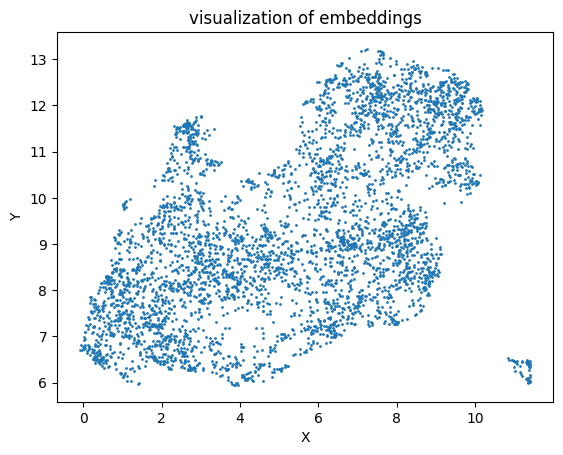

In [53]:
import matplotlib.pyplot as plt
x = [point[0] for point in umap_emb]
y = [point[1] for point in umap_emb]

plt.scatter(x, y, s=1)

plt.title('visualization of embeddings')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [73]:
def generate_prompt_agent1(diagnosis,index, paragraphs,top_k=5,num_paragraphs=2):
    relevant_paragraphs = retrieve_relevant_paragraphs(''.join(diagnosis), index, paragraphs, top_k=top_k)
    random_paragraphs = np.random.choice(relevant_paragraphs, num_paragraphs, False)
    prompt = (f'Отвечай на русском. Придумай клиническую картинку для следующего ветеренарного заболевания: {diagnosis[0]}. Она должна содержать не больше 50 слов. В ней не должно быть называния заболевания.'
             'Вот полезеная информации для тебя:\n'+''.join([f'{num+1}) '+s+'\n' for num,s in enumerate(random_paragraphs)]))
    return prompt

In [76]:
data_agent1 = []
for diagnosis in diagnoses:
    data_agent1 += [generate_prompt_agent1(diagnosis,index, paragraphs,top_k=10,num_paragraphs=2) for i in range(10)]

In [77]:
DataSeries = pd.Series(data_agent1)

In [80]:
for prompt in data_agent1:
    print(prompt)

Отвечай на русском. Придумай клиническую картинку для следующего ветеренарного заболевания: Отит. Она должна содержать не больше 50 слов. В ней не должно быть называния заболевания.Вот полезеная информации для тебя:
1) токсичность, вредное влияние различных веществ на живой организм. Токсическое действие оказывают некоторые химические соединения: фенолы, крезолы, цианиды, соединения тяжёлых металлов (особенно соединения ртути), препараты мышьяка, хлорорганические и фосфорорганические пестициды и др., а также продукты разложения белков (гистамин, путресцин, кадаверин) и др. Т. могут обладать некоторые лекарственные средства в случаях их передозировок, повышенной чувствительности к ним организма. Т. лекарственных препаратов может выражаться также во вредном влиянии их на органы и системы в качестве побочного действия токсические вещества (токсины) продуцируют бактерии и животные (насекомые, змеи), растения.
2) натрия сульфат (Natrii sulfas; ФХ), глауберова соль, слабительное средство. Бе

In [83]:
print('Сейчас я отправлю тебе клиническую картинку больного животного. Ты должен выделить из нее основные симптомы.\nВот пример как должен выглядеть твой ответ:\"симптомы:боль в ухе,гнойные выделения из уха,зуд и дискомфорт\". Твой ответ должен строго следовать такому формату!\nКлиническая картина:')


Сейчас я отправлю тебе клиническую картинку больного животного. Ты должен выделить из нее основные симптомы.
Вот пример как должен выглядеть твой ответ:"симптомы:боль в ухе,гнойные выделения из уха,зуд и дискомфорт". Твой ответ должен строго следовать такому формату!
Клиническая картина:


In [79]:
DataSeries.to_csv('prompt_to_mn.csv', index=False)

In [103]:
print(generate_prompt_agent1(diagnoses[-2],index, paragraphs,top_k=5,num_paragraphs=2))

(1, 768)
count of relevant paragraphs =  5
Отвечай на русском. Придумай клиническую картинку для следующего ветеренарного заболевания: Аллергические реакции.Вот полезеная информации для тебя:
1) Чаще всего причинами заболевания является голодание, содержание овец на рационах, неполноценных по общей, протеиновой и витаминной питательности, в конце суягности. Возникает заболевание также как вторичное, при ацидозе на почве перекорма концкормами. Заболевают чаще многоплодные овцематки.
2) Тимпания может появиться и при поедании животными загнивших корнеплодов, мороженых и заплесневелых кормов, некоторых ядовитых трав, а также при закупорке пищевода. У телят вздутие рубца возникает чаще всего при резком переходе кормления молоком к скармливанию болтушек из концентрированных кормов.



In [67]:
all_vectors.shape

(7609, 768)

In [89]:
set_of_relevant = retrieve_relevant_paragraphs('недосток витаминов, авитаминоз', index, paragraphs, top_k=5)

(1, 768)
count of relevant paragraphs =  5


In [90]:
for i in set_of_relevant:
    print(i,end='\n\n\n')

Лечение направлено на устранение основной причины. Применяются общеукрепляющие средства (глюкоза, сыворотка по Кадыкову), витамины группы B и D. Органная А. возникает как следствие функционального истощения на почве гиперфункции или нарушения регуляторных механизмов, например А. сердца при миокардитах.


Этиология и патогенез окончательно не выяснены. Паралитическую М. л. обычно наблюдают у взрослых хорошо упитанных лошадей при обильном их кормлении, отсутствии моциона, при резком переходе к работе после вынужденного отдыха. Энзоотическая М. л. регистрируется в северных и средних географических широтах осенью и зимой и может принимать массовое распространение, поражая все возрастные группы лошадей; возникает в связи с неполноценным кормлением (недостаток в рационе белка, витаминов, минеральных веществ). Паралитическая М. л. возникает внезапно в первые часы работы, энзоотическая — развивается постепенно и имеет длительный период скрытого течения. Основные признаки М. л.: шаткая походка 